In [93]:
import seaborn as sns
import sys, os, re, csv, codecs, numpy as np, pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D,Bidirectional
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
import matplotlib.pyplot as plt
%matplotlib inline
import gensim.models.keyedvectors as word2vec
import gc


import string
import re    #for regex
import nltk
from nltk.corpus import stopwords
import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
# Tweet tokenizer does not split at apostophes which is what we want
from nltk.tokenize import TweetTokenizer   

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

In [94]:
#그래프에 한글 출력
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [95]:
eng_stopwords = set(stopwords.words("english"))
lem = WordNetLemmatizer()
color = sns.color_palette()

## train, test 불러오기

In [96]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
embed_size=0

In [97]:
train['identity_hate'].unique()

array([0, 1], dtype=int64)

In [98]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [99]:
# , , , 위협, 모욕
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

In [100]:
y = train[list_classes].values
list_sentences_train = train["comment_text"]
list_sentences_test = test["comment_text"]

#### EDA

In [101]:

x=train.iloc[:,2:].sum()
#marking comments without any tags as "clean"
rowsums=train.iloc[:,2:].sum(axis=1)
train['clean']=(rowsums==0)
#count number of clean entries
train['clean'].sum()
print("Total comments = ",len(train))
print("Total clean comments = ",train['clean'].sum())
print("Total tags =",x.sum())

Total comments =  159571
Total clean comments =  143346
Total tags = 35098


In [102]:
train.isnull().any(),test.isnull().any()
#결측치 없음.

(id               False
 comment_text     False
 toxic            False
 severe_toxic     False
 obscene          False
 threat           False
 insult           False
 identity_hate    False
 clean            False
 dtype: bool, id              False
 comment_text    False
 dtype: bool)

In [103]:
# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(list(list_sentences_train))
# list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
# list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

In [104]:
#우선 max_features 20000으로
max_features = 20000
#tokenizing
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

#### 패딩

In [105]:
len(list_tokenized_train)

159571

In [106]:
length = 0
for i in range(len(list_tokenized_train)):
    length += len(list_tokenized_train[i])

In [107]:
length/len(list_tokenized_train)
#length 평균: 65.41

65.41466181198338

##### 문장 길이 시각화

In [108]:
length_list = []
for i in range(len(list_tokenized_train)):
    length_list.append(len(list_tokenized_train[i]))

In [109]:
maxlen = 250
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [110]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]

In [111]:
list_tokenized_train

[[688,
  75,
  1,
  126,
  130,
  177,
  29,
  672,
  4511,
  12052,
  1116,
  86,
  331,
  51,
  2278,
  11448,
  50,
  6864,
  15,
  60,
  2756,
  148,
  7,
  2937,
  34,
  117,
  1221,
  15190,
  2825,
  4,
  45,
  59,
  244,
  1,
  365,
  31,
  1,
  38,
  27,
  143,
  73,
  3462,
  89,
  3085,
  4583,
  2273,
  985],
 [52,
  2635,
  13,
  555,
  3809,
  73,
  4556,
  2706,
  21,
  94,
  38,
  803,
  2679,
  992,
  589,
  8377,
  182],
 [412,
  437,
  73,
  134,
  14,
  249,
  2,
  71,
  314,
  78,
  50,
  9,
  13,
  626,
  8,
  2284,
  492,
  502,
  102,
  4,
  611,
  2,
  35,
  325,
  126,
  363,
  3,
  29,
  38,
  27,
  52,
  208,
  2,
  434,
  57,
  36,
  1,
  2394,
  93,
  1,
  737,
  468],
 [57,
  7,
  228,
  97,
  54,
  328,
  1436,
  15,
  2133,
  7,
  6024,
  22,
  1,
  123,
  2502,
  56,
  16,
  513,
  15,
  25,
  5,
  4236,
  3,
  1327,
  3,
  9762,
  7,
  67,
  1,
  277,
  85,
  122,
  13503,
  37,
  9,
  51,
  19,
  42,
  10,
  1,
  1460,
  138,
  1257,
  2153,
  426,
 

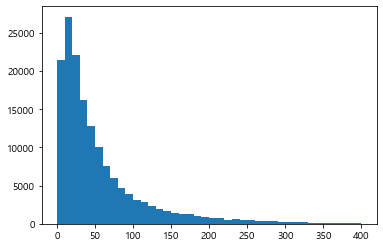

In [112]:
plt.hist(totalNumWords,bins = np.arange(0,410,10))#[0,50,100,150,200,250,300,350,400])#,450,500,550,600,650,700,750,800,850,900])
plt.show()
#250으로 두는게 나을듯

### Class Imbalance

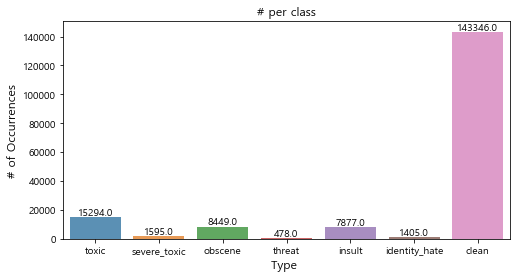

In [113]:
x=train.iloc[:,2:].sum()
#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

### Multiple tags

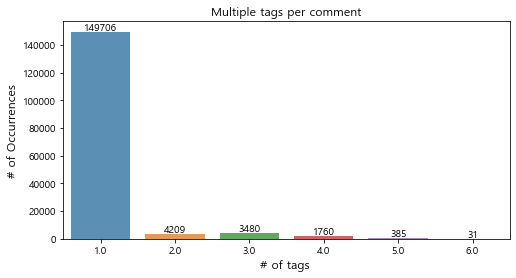

In [114]:
rowsums=train.iloc[:,2:].sum(axis=1)
x=rowsums.value_counts()

#plot
plt.figure(figsize=(8,4))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Multiple tags per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of tags ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [115]:
temp_df=train.iloc[:,2:-1]

In [116]:
#Crosstab
# Since technically a crosstab between all 6 classes is impossible to vizualize, lets take a 
# look at toxic with other tags
main_col="toxic"
corr_mats=[]
for other_col in temp_df.columns[1:]:
    confusion_matrix = pd.crosstab(temp_df[main_col], temp_df[other_col])
    corr_mats.append(confusion_matrix)
out = pd.concat(corr_mats,axis=1,keys=temp_df.columns[1:])

#cell highlighting
#out = out.style.apply(highlight_min,axis=0)
#out

In [117]:
out

severe_toxic       obscene        threat       insult        \
severe_toxic            0     1       0     1       0    1       0     1   
toxic                                                                      
0                  144277     0  143754   523  144248   29  143744   533   
1                   13699  1595    7368  7926   14845  449    7950  7344   

             identity_hate        
severe_toxic             0     1  
toxic                             
0                   144174   103  
1                    13992  1302


### 예시

In [118]:
print("toxic:")
print(train[train.severe_toxic==1].iloc[3,1])
#print(train[train.severe_toxic==1].iloc[5,1])

toxic:
Hi 

Im a fucking bitch.

50.180.208.181


In [119]:
print(train[train.severe_toxic==1].iloc[4,1])
#print(train[train.severe_toxic==1].iloc[4,1])

What a motherfucking piece of crap those fuckheads for blocking us!


In [120]:
print("Threat:")
print(train[train.threat==1].iloc[1,1])
#print(train[train.threat==1].iloc[2,1])

Threat:
I think that your a Fagget get a oife and burn in Hell I hate you 'm sorry we cant have any more sex i'm running out of conndoms


In [121]:
print("Obscene:") #역겨운
print(train[train.obscene==1].iloc[1,1])
#print(train[train.obscene==1].iloc[2,1])

Obscene:
You are gay or antisemmitian? 

Archangel WHite Tiger

Meow! Greetingshhh!

Uh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...

1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!

2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals!

3 - First and last warning, you fucking gay - I won't appreciate if any more nazi shwain would write in my page! I don't wish to talk to you anymore!

Beware of the Dark Side!


In [122]:
print("identity_hate:")
print(train[train.identity_hate==1].iloc[4,1])
#print(train[train.identity_hate==1].iloc[4,1])

identity_hate:
u r a tw@ fuck off u gay boy.U r smelly.Fuck ur mum poopie


In [123]:
from wordcloud import WordCloud ,STOPWORDS

In [124]:

stopword=set(STOPWORDS)

In [125]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,True
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,True
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,True
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,True
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,True


In [126]:
subset=train[train.clean==True]

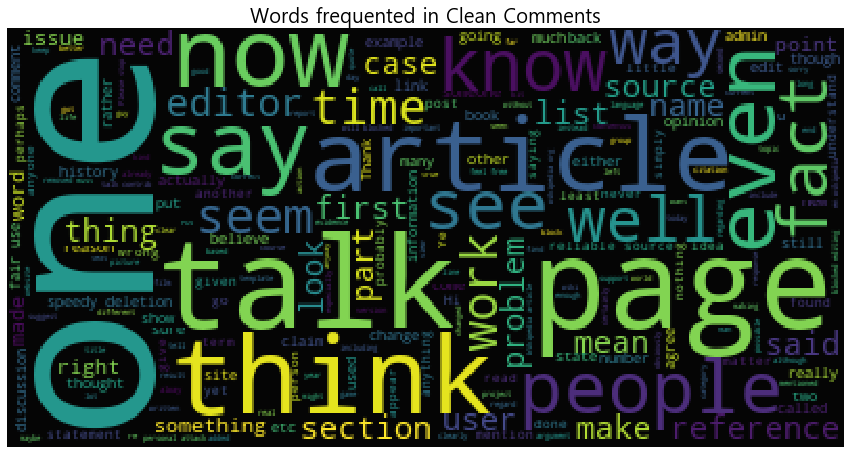

In [127]:
#wordcloud for clean comments
subset=train[train.clean==True]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(15,8))
plt.axis("off")
plt.title("Words frequented in Clean Comments", fontsize=20)

plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

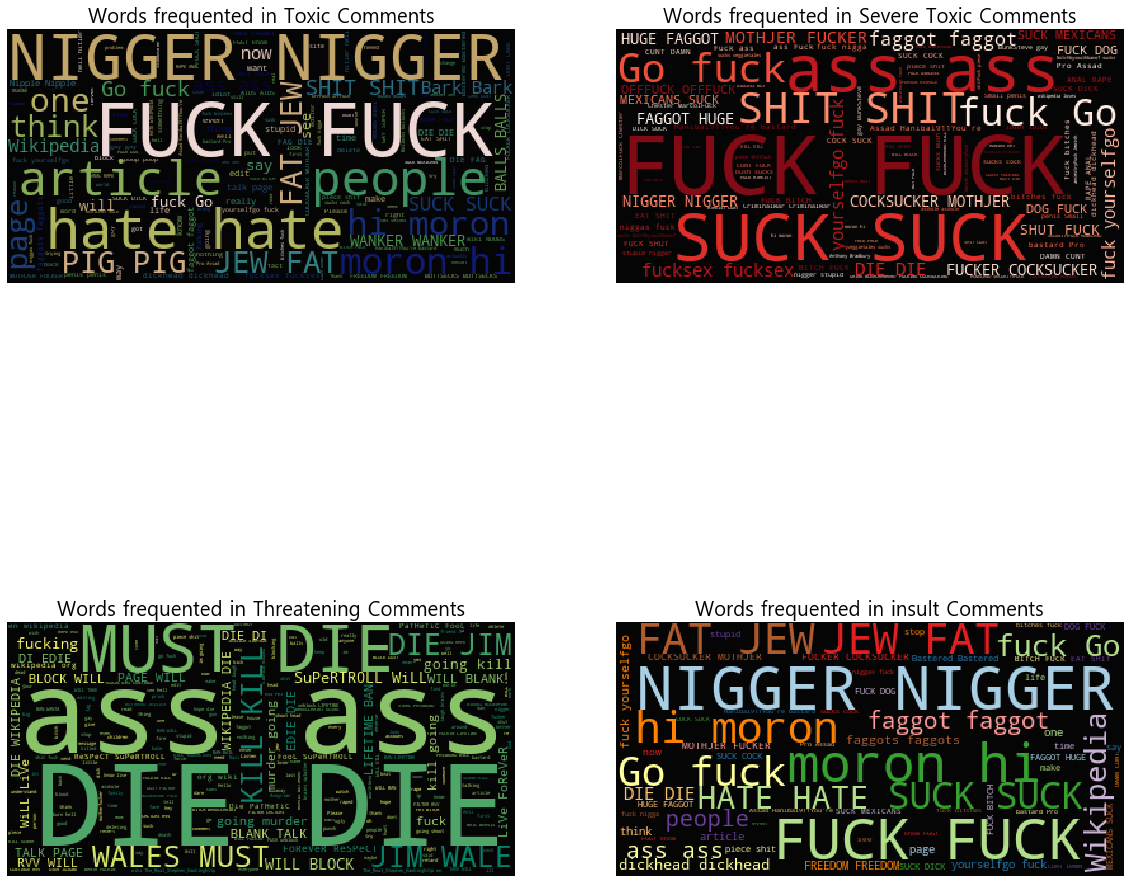

In [128]:
#wordcloud for clean comments
subset=train[train.toxic==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=4000,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.axis("off")
plt.title("Words frequented in Toxic Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=244), alpha=0.98)

#Severely toxic comments
plt.subplot(222)

subset=train[train.severe_toxic==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in Severe Toxic Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Reds' , random_state=244), alpha=0.98)

#Threat comments
plt.subplot(223)

subset=train[train.threat==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in Threatening Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'summer' , random_state=2534), alpha=0.98)

#insult
plt.subplot(224)

subset=train[train.insult==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in insult Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Paired_r' , random_state=244), alpha=0.98)

plt.show()

### Feature Engineering

In [129]:
merge=pd.concat([train.iloc[:,0:2],test.iloc[:,0:2]])
df=merge.reset_index(drop=True)

In [130]:
df

,id,comment_text
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It..."
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ..."
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember..."
...,...,...
312730,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu..."
312731,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...
312732,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ..."
312733,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the..."


#### 파생변수들

In [131]:
## Indirect features

#Sentense count in each comment:
    #  '\n' can be used to count the number of sentences in each comment
df['count_sent']=df["comment_text"].apply(lambda x: len(re.findall("\n",str(x)))+1)
#Word count in each comment:
df['count_word']=df["comment_text"].apply(lambda x: len(str(x).split()))
#Unique word count
df['count_unique_word']=df["comment_text"].apply(lambda x: len(set(str(x).split())))
#Letter count
df['count_letters']=df["comment_text"].apply(lambda x: len(str(x)))
#punctuation count
df["count_punctuations"] =df["comment_text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
#upper case words count
df["count_words_upper"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
#title case words count
df["count_words_title"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
#Number of stopwords
df["count_stopwords"] = df["comment_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
#Average length of the words
df["mean_word_len"] = df["comment_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [132]:
#derived features
#Word count percent in each comment:
df['word_unique_percent']=df['count_unique_word']*100/df['count_word']
#derived features
#Punct percent in each comment:
df['punct_percent']=df['count_punctuations']*100/df['count_word']

In [133]:
#serperate train and test features
train_feats=df.iloc[0:len(train),]
test_feats=df.iloc[len(train):,]
#join the tags
train_tags=train.iloc[:,2:]
train_feats=pd.concat([train_feats,train_tags],axis=1)

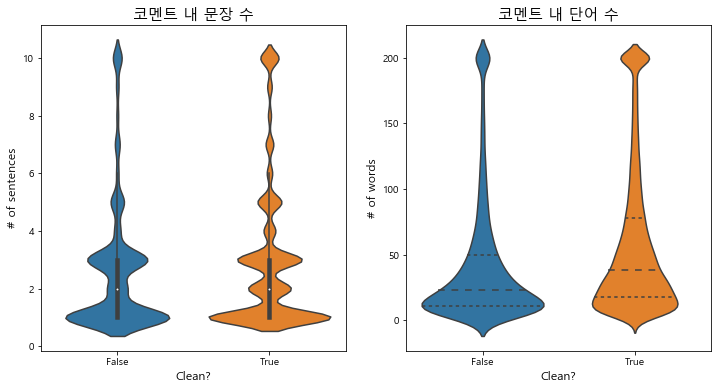

In [134]:
train_feats['count_sent'].loc[train_feats['count_sent']>10] = 10 
plt.figure(figsize=(12,6))
## sentenses
plt.subplot(121)
#plt.suptitle("Are longer comments more toxic?",fontsize=20)
sns.violinplot(y='count_sent',x='clean', data=train_feats,split=True)
plt.xlabel('Clean?', fontsize=12)
plt.ylabel('# of sentences', fontsize=12)
plt.title("코멘트 내 문장 수", fontsize=15)
# words
train_feats['count_word'].loc[train_feats['count_word']>200] = 200
plt.subplot(122)
sns.violinplot(y='count_word',x='clean', data=train_feats,split=True,inner="quart")
plt.xlabel('Clean?', fontsize=12)
plt.ylabel('# of words', fontsize=12)
plt.title("코멘트 내 단어 수", fontsize=15)

plt.show()

In [135]:
train_feats['count_unique_word'].loc[train_feats['count_unique_word']>200] = 200
#prep for split violin plots
#For the desired plots , the data must be in long format
temp_df = pd.melt(train_feats, value_vars=['count_word', 'count_unique_word'], id_vars='clean')
#spammers - comments with less than 30% unique words
spammers=train_feats[train_feats['word_unique_percent']<30]

In [136]:
import matplotlib.gridspec as gridspec 

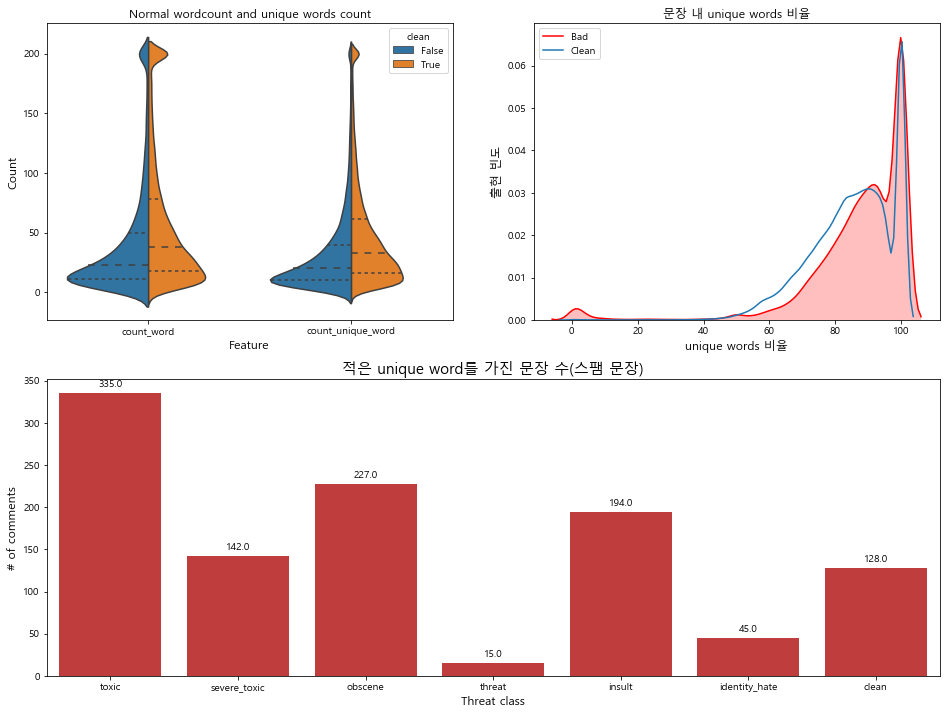

In [137]:
plt.figure(figsize=(16,12))
#plt.suptitle("What's so unique ?",fontsize=20)
gridspec.GridSpec(2,2)
plt.subplot2grid((2,2),(0,0))
sns.violinplot(x='variable', y='value', hue='clean', data=temp_df,split=True,inner='quartile')
plt.title("Normal wordcount and unique words count")
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.subplot2grid((2,2),(0,1))
plt.title("문장 내 unique words 비율")
#sns.boxplot(x='clean', y='word_unique_percent', data=train_feats)
ax=sns.kdeplot(train_feats[train_feats.clean == 0].word_unique_percent, label="Bad",shade=True,color='r')
ax=sns.kdeplot(train_feats[train_feats.clean == 1].word_unique_percent, label="Clean")
plt.legend()
plt.ylabel('출현 빈도', fontsize=12)
plt.xlabel('unique words 비율', fontsize=12)

x=spammers.iloc[:,-7:].sum()
plt.subplot2grid((2,2),(1,0),colspan=2)
plt.title("적은 unique word를 가진 문장 수(스팸 문장)",fontsize=15)
ax=sns.barplot(x=x.index, y=x.values,color=color[3])

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.xlabel('Threat class', fontsize=12)
plt.ylabel('# of comments', fontsize=12)
plt.show()

* 나쁜 말은 적은 수의 단어로 이루어짐
* toxic comment의 종류마다 unique word의 비율이 다름(threat가 상당히 낮음)

### 스팸 메시지 걸러내기

In [138]:
print("Clean Spam example:")
print(spammers[spammers.clean==1].comment_text.iloc[1])
print("Toxic Spam example:")
print(spammers[spammers.toxic==1].comment_text.iloc[2])

Clean Spam example:
Towns and Villages in Ark-La-Tex]]
 Cities, boroughs and towns in the Republic of Ireland
 Cities, boroughs, and townships along the Susquehanna River
 Cities, towns and villages in Alborz Province
 Cities, towns and villages in Ardabil Province
 Cities, towns and villages in Bhutan
 Cities, towns and villages in Bushehr Province
 Cities, towns and villages in Chaharmahal and Bakhtiari Province
 Cities, towns and villages in Cyprus
 Cities, towns and villages in Dutch Limburg
 Cities, towns and villages in East Azerbaijan Province
 Cities, towns and villages in East Timor
 Cities, towns and villages in Fars Province
 Cities, towns and villages in Flevoland
 Cities, towns and villages in Friesland
 Cities, towns and villages in Gelderland
 Cities, towns and villages in Gilan Province
 Cities, towns and villages in Golestan Province
 Cities, towns and villages in Groningen
 Cities, towns and villages in Hamadan Province
 Cities, towns and villages in Hormozgan Provinc

In [139]:
corpus=merge.comment_text

In [140]:
tokenizer=TweetTokenizer()

In [141]:
def clean(comment):
    """
    This function receives comments and returns clean word-list
    """
    #Convert to lower case , so that Hi and hi are the same
    comment=comment.lower()
    #remove \n
    comment=re.sub("\\n","",comment)
    # remove leaky elements like ip,user
    comment=re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}","",comment)
    #removing usernames
    comment=re.sub("\[\[.*\]","",comment)
    
    #Split the sentences into words
    #words = tokenizer.fit_on_texts(comment)
    words=tokenizer.tokenize(comment)
    
    # (')aphostophe  replacement (ie)   you're --> you are  
    # ( basic dictionary lookup : master dictionary present in a hidden block of code)
    words=[APPO[word] if word in APPO else word for word in words]
    words=[lem.lemmatize(word, "v") for word in words]
    words = [w for w in words if not w in eng_stopwords]
    
    clean_sent=" ".join(words)
    # remove any non alphanum,digit character
    #clean_sent=re.sub("\W+"," ",clean_sent)
    #clean_sent=re.sub("  "," ",clean_sent)
    return(clean_sent)

In [142]:
APPO = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"tryin'":"trying"
}

In [143]:
clean(corpus.iloc[12235])

'" note read , follow link , reader see cite correctly link add subject . vidkun add anotations make read oposite , link show " " official " " line take ugle . trap user so-called 3rr , peddle pov . strangly , " " masons " " quiet , leave ‘ ‘ ’ ’ defend factual truth . " " thank " " brethren . sit block give ... "'

In [144]:
clean_corpus=corpus.apply(lambda x :clean(x))

### TF-IDF Vectorizer

In [145]:

tfv = TfidfVectorizer(min_df=200,  max_features=10000, 
            strip_accents='unicode', analyzer='word',ngram_range=(1,1),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')
tfv.fit(clean_corpus)
features = np.array(tfv.get_feature_names())

train_unigrams =  tfv.transform(clean_corpus.iloc[:train.shape[0]])
test_unigrams = tfv.transform(clean_corpus.iloc[train.shape[0]:])